# 1. Get datasets from Google Drive

- To get the datasets from Google Drive, I created a new Project in Google Cloud Console and created OAuth 2.0 Credentials to obtain the "client_secrets.json" file.

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Download data from google drive 
def get_data(folder_id, api_key):
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth()
    drive = GoogleDrive(gauth)

    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in file_list:
        print(f"Downloading {file['title']}...")
        file.GetContentFile(file['title'])

    return file_list

In [4]:
# The provided credential needed to access the data
folder_id = 'your_folder_id'
api_key = "your_api_key"

file_list = get_data(folder_id, api_key)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=643459961581-imf9juir3qbekns3sqer1m05s76asahb.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


# 2. Feature Engineering

- For feature engineering, the function transforms categorical variables into numerical formats and creates new features such as "desc_length" and "price_per_sqft," as these could potentially influence the price.

In [1]:
def feature_engineering(data):
    print('Initial data size:', data.shape)
    # Drop rows with missing key values
    data = data.dropna(subset=['description', 'sqfeet', 'price'])
    print('Data size after cleaning:', data.shape)

    # Create new features
    data = data.copy()
    data.loc[:, 'desc_length'] = data['description'].str.len()
    data.loc[:, 'price_per_sqft'] = data['price'] / data['sqfeet'].replace(0, np.nan)

    # Convert categorical features to numerical
    categorical_columns = ['region', 'type', 'laundry_options', 'parking_options', 'state']
    categorical_columns = [col for col in categorical_columns if col in data.columns]
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

    # Drop unnecessary columns
    data = data.drop(['id', 'description'], axis=1, errors='ignore')
    
    return data

# 3. Model Training

- To find the best model, three models are trained: the Gradient Boosting (GB) model, the K-Nearest Neighbors (KNN) model, and the Random Forest (RF) model. Their performance was evaluated using metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the coefficient of determination (R²).

In [2]:
def evaluate_model(y_true, y_pred):
    y_pred_exp = np.expm1(y_pred)
    y_true_exp = np.expm1(y_true)

    mae = mean_absolute_error(y_true_exp, y_pred_exp)
    mse = mean_squared_error(y_true_exp, y_pred_exp)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_true_exp, y_pred_exp)

    print("\nModel Evaluation Metrics:")
    print(f"{'Metric':<10} | {'Value':>10}")
    print("-" * 25)
    print(f"{'MAE':<10} | {mae:>10.2f}")
    print(f"{'RMSE':<10} | {rmse:>10.2f}")
    print(f"{'R²':<10} | {r2:>10.4f}")

### GB model

In [3]:
def train_gb_model(X_train, y_train):
    print("Training GB model...")
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    return gb_model

### KNN model

In [4]:
def train_knn_model(X_train, y_train):
    print("Training KNN model...")
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    return knn_model

### RF model

In [5]:
def train_rf_model(X_train, y_train):
    print("Training RF model...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

In [6]:
def pipeline(train_data):
    # Perform feature engineering on the dataset
    train_data = feature_engineering(train_data)

    # Separate features and target
    X = train_data.drop('price', axis=1)
    y = np.log1p(train_data['price'].clip(lower=1))

    # Split data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Handle missing values and scale features
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    # Fit and transform the training data
    X_train_split = pd.DataFrame(imputer.fit_transform(X_train_split), columns=X.columns)
    X_val_split = pd.DataFrame(imputer.transform(X_val_split), columns=X.columns)
    X_train_split = pd.DataFrame(scaler.fit_transform(X_train_split), columns=X.columns)
    X_val_split = pd.DataFrame(scaler.transform(X_val_split), columns=X.columns)

    # Save the column names for feature alignment
    feature_columns = X_train_split.columns.tolist()

    # Train the models
    gb_model = train_gb_model(X_train_split, y_train_split)
    knn_model = train_knn_model(X_train_split, y_train_split)
    rf_model = train_rf_model(X_train_split, y_train_split)

    # Evaluate the models
    print("Evaluating GB model...")
    y_val_pred = gb_model.predict(X_val_split)
    evaluate_model(y_val_split, y_val_pred)

    print("Evaluating KNN model...")
    y_val_pred = knn_model.predict(X_val_split)
    evaluate_model(y_val_split, y_val_pred)

    print("Evaluating RF model...")
    y_val_pred = rf_model.predict(X_val_split)
    evaluate_model(y_val_split, y_val_pred)

    return gb_model, knn_model, rf_model, imputer, scaler, feature_columns

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load training data
train_data = pd.read_csv('../datasets/train_set.csv')
gb_model, knn_model, rf_model, imputer, scaler, feature_columns = pipeline(train_data)

Initial data size: (346479, 19)
Data size after cleaning: (346477, 19)
Training GB model...
Training KNN model...
Training RF model...
Evaluating GB model...

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |     267.27
RMSE       |   42045.90
R²         |     0.5030
Evaluating KNN model...

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |     226.28
RMSE       |    7349.30
R²         |     0.9848
Evaluating RF model...

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |     236.16
RMSE       |   39874.31
R²         |     0.5530


- Based on the evaluation metrics, the KNN Model is the best performer, followed by the RF Model, with the GB Model being the least effective in this comparison. KNN model has the lowest error (MAE, MSE, RMSE) and the highest R², suggesting it is the best model in terms of accuracy and fit.

# 4. Model Inference

- To reference the model, the "test_set.csv" dataset is used to predict prices and compared the predicted values with their corresponding ground truth prices, using all three models.

In [8]:
print("\nPerforming inference on test data...")
test_data = pd.read_csv('../datasets/test_set.csv')
ground_truth_price = test_data['price']

test_data = feature_engineering(test_data)
X_test = test_data.drop('price', axis=1, errors='ignore')

# Align test data with training features
for col in feature_columns:
    if col not in X_test.columns:
        X_test[col] = 0 
X_test = X_test[feature_columns]

# Use the same imputer and scaler fitted on training data
X_test = pd.DataFrame(imputer.transform(X_test), columns=feature_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_columns)

# Make predictions using the models
test_pred_log_knn = knn_model.predict(X_test)
test_pred_price_knn = np.expm1(test_pred_log_knn)
print("\nKNN Test Set Evaluation:")
evaluate_model(np.log1p(ground_truth_price), test_pred_log_knn)

test_pred_log_gb = gb_model.predict(X_test)
test_pred_price_gb = np.expm1(test_pred_log_gb)
print("\nGradient Boosting Test Set Evaluation:")
evaluate_model(np.log1p(ground_truth_price), test_pred_log_gb)

test_pred_log_rf = rf_model.predict(X_test)
test_pred_price_rf = np.expm1(test_pred_log_rf)
print("\nRandom Forest Test Set Evaluation:")
evaluate_model(np.log1p(ground_truth_price), test_pred_log_rf)


Performing inference on test data...
Initial data size: (38498, 19)
Data size after cleaning: (38498, 19)

KNN Test Set Evaluation:

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |   71996.27
RMSE       | 14048287.57
R²         |     0.0086

Gradient Boosting Test Set Evaluation:

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |   71958.83
RMSE       | 14059007.62
R²         |     0.0071

Random Forest Test Set Evaluation:

Model Evaluation Metrics:
Metric     |      Value
-------------------------
MAE        |   71944.38
RMSE       | 14072663.73
R²         |     0.0052


In [17]:
# Combine the predictions into one DataFrame
comparison = pd.DataFrame({
    'Ground Truth Price': ground_truth_price,
    'KNN Predicted Price': test_pred_price_knn,
    'GB Predicted Price': test_pred_price_gb,
    'RF Predicted Price': test_pred_price_rf
})

print("\nSample Predictions from All Models:")
comparison.head(20)


Sample Predictions from All Models:


,Ground Truth Price,KNN Predicted Price,GB Predicted Price,RF Predicted Price
0,1750,1266.351595,1695.919802,1750.495617
1,850,850.000000,836.913167,850.000000
2,1500,1502.988079,1484.414493,1500.000000
3,899,694.576717,911.733468,899.759367
4,595,640.528017,588.482910,603.000001
5,899,890.946025,896.857264,899.000000
6,805,829.662658,800.362582,805.038487
7,1300,1543.934554,1295.854372,1299.787700
8,735,810.084546,758.099153,733.903373
9,1070,1041.539163,1057.983976,1069.989995


- Although the KNN model performed the best in the previous step (Model Training) using the validation set, it shows significant underestimation for several values. This suggests that the KNN model might be overfitting to the validation data. In contrast, the GB model is generally closer to the ground truth. However, the RF model performs the best overall, with most predicted prices closely aligning with the actual prices. In general, RF and GB provide more accurate predictions than KNN in most cases.

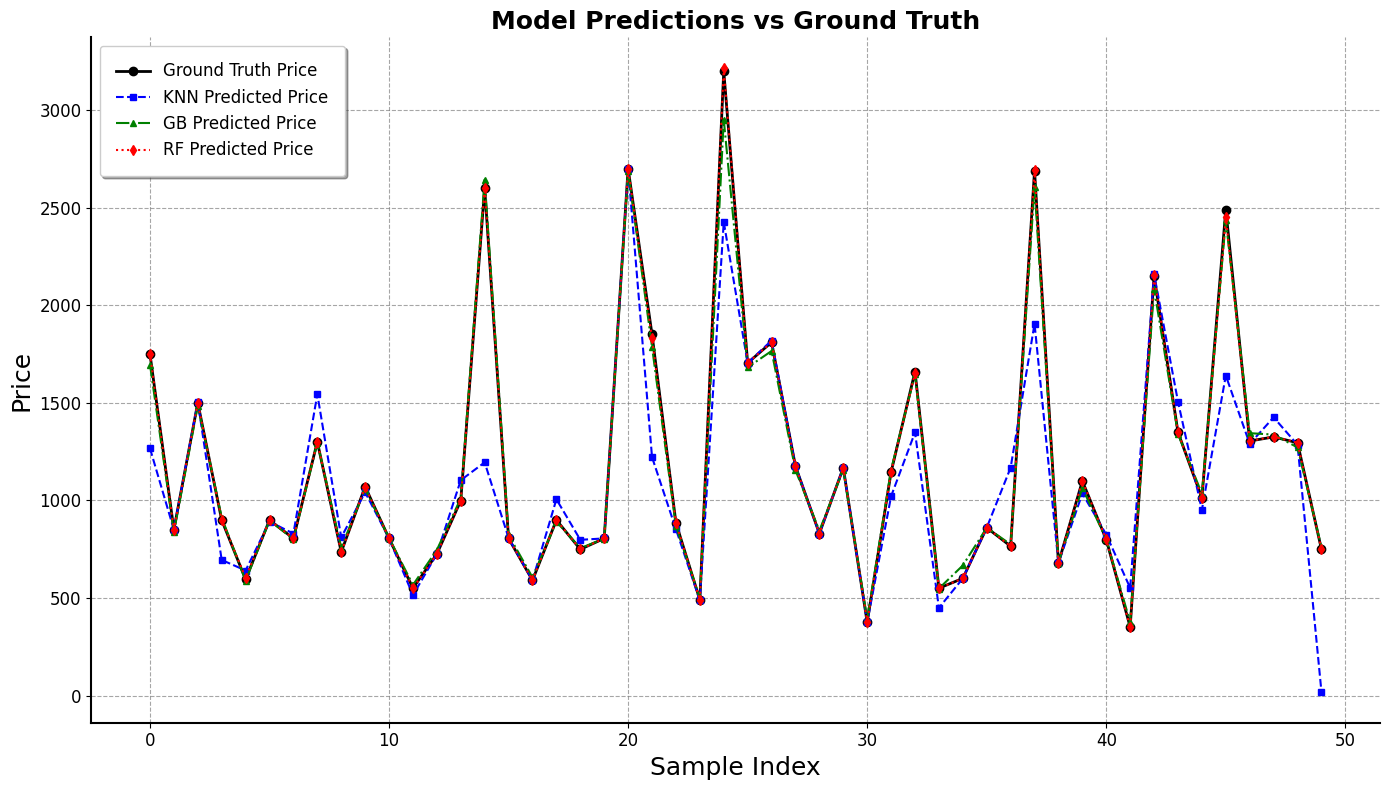

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(
    range(50), 
    comparison['Ground Truth Price'][:50], 
    label='Ground Truth Price', 
    marker='o', 
    linestyle='-', 
    color='black', 
    markersize=6, 
    linewidth=2
)
plt.plot(
    range(50), 
    comparison['KNN Predicted Price'][:50], 
    label='KNN Predicted Price', 
    marker='s', 
    linestyle='--', 
    color='blue', 
    markersize=5, 
    linewidth=1.5
)
plt.plot(
    range(50), 
    comparison['GB Predicted Price'][:50], 
    label='GB Predicted Price', 
    marker='^', 
    linestyle='-.', 
    color='green', 
    markersize=5, 
    linewidth=1.5
)
plt.plot(
    range(50), 
    comparison['RF Predicted Price'][:50], 
    label='RF Predicted Price', 
    marker='d', 
    linestyle=':', 
    color='red', 
    markersize=5, 
    linewidth=1.5
)

plt.title('Model Predictions vs Ground Truth', fontsize=18, fontweight='bold')
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True, borderpad=1)
plt.grid(color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.savefig('../figures/model_predictions_comparison.png', dpi=300, bbox_inches='tight')

plt.show()
